<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/07/0714.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%capture
!pip install umap-learn umap-learn[plot] kmodes kneed
!wget -O consts.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/07/0714_consts.py?raw=1
!wget -O 0714_soybean_data_use.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0714_soybean_data_use.csv?raw=1

## K-modes demo

In [6]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import adjusted_rand_score

from yellowbrick.cluster import SilhouetteVisualizer

import umap
import umap.plot as uplot

from kmodes.kmodes import KModes

from kneed import KneeLocator

from consts import SOY_FEATURE_DESCRIPTION

# KElbowVisualizer from Yellowbrick is not compatible with K-modes

plt.rcParams["figure.figsize"] = (11,7)
sns.set_theme()

### Soyabeen small dataset

A dataset of soybean plant observations, including information on plants infested by one of four diseases.

- Dataset contains 47 instances.
- Each instance represents a single plant.
- Characterized by 35 attributes.
- Attributes are categorical.
- Attributes mostly capture various symptoms like leaf spots, root rot, mold growth, seed damage, etc.

Citation:

- Michalski,R.. (1987). Soybean (Small). UCI Machine Learning Repository. https://doi.org/10.24432/C5DS3P.

The goal of the dataset is to diagnose four different types of diseases: D1 (diaporthe stem canker), D2 (charcoal rot), D3 (rhizoctonia root rot) and D4 (phytophthora root rot). Therefore, the target variable in the dataset is the type of disease, which has four different classes.

### Features:


1. **Date**: Represents the specific time of soybean sample collection, crucial for understanding seasonal impacts on plant health.
  
2. **Plant Stand**: Qualitatively assesses the uniformity and health of the plant population, informing about possible early-stage diseases or growth issues.

3. **Precipitation**: Captures the water level conditions around the sampling time, providing insights into potential water-related stress factors.
  
4. **Temperature**: Reflects the average climatic temperature at the time of observation, crucial for assessing environmental stress conditions.

5. **Hail**: A binary indicator that identifies whether the plant has undergone hail damage, which could affect overall plant health.

6. **Crop Hist**: Denotes the type of crop previously grown in the same field, essential for understanding soil quality and disease carryover risks.

7. **Area Damaged**: Quantifies the spatial extent of observable damage, useful for gauging the disease's progression.

8. **Severity**: Categorizes the observable symptoms into different severity levels, aiding in diagnostic precision.

9. **Seed Tmt**: Indicates whether the seeds underwent any treatment before planting, offering clues to possible resistance against diseases.

10. **Germination**: Measures the proportion of seeds that successfully sprouted, a potential early indicator of crop health.

11. **Plant Growth**: Describes the overall plant morphology, allowing for assessments of nutritional status or genetic factors.

12. **Leaves**: Evaluates leaf condition, which is often the first site of symptom expression in many plant diseases.

13. **Leafspots Halo**: Details the characteristics of leaf spots, such as color and shape, aiding in disease identification.

14. **Leafspots Margins**: Describes the edge characteristics of any leaf spots, essential for distinguishing between multiple diseases.

15. **Leafspot Size**: Categorizes the dimensions of leaf spots, crucial for severity assessment.

16. **Leaf Shread**: A binary flag for the presence of leaf shredding, often indicative of mechanical damage or specific diseases.

17. **Leaf Malf**: A binary indicator for the presence of deformities in the leaves, which may suggest genetic or environmental stresses.

18. **Leaf Mild**: Indicates the presence or absence of mildew on the leaves, a common symptom for various fungal diseases.

19. **Stem**: Assesses the stem's physical condition, another critical site for symptom manifestation.

20. **Lodging**: A binary flag that notes whether the plant is upright or has fallen, often indicative of structural weakness or disease.

21. **Stem Cankers**: Details the characteristics of stem cankers if present, essential for identifying specific stem diseases.

22. **Canker Lesion**: Documents the type and appearance of canker lesions on the stem, crucial for diagnostic accuracy.

23. **Fruiting Bodies**: A binary indicator of the presence of fruiting bodies, suggesting advanced stages of certain fungal diseases.

24. **External Decay**: Flags the presence of decay on the plant's exterior, indicative of severe fungal or bacterial infection.

25. **Mycelium**: A binary indicator for the presence of fungal mycelium, a sign of fungal diseases.

26. **Int Discolor**: Flags internal discoloration, often indicative of systemic infections.

27. **Sclerotia**: Indicates the presence of sclerotial bodies, commonly associated with advanced fungal diseases.

28. **Fruit Pods**: Evaluates the overall health of the fruit pods, crucial for assessing the final yield quality.

29. **Fruit Spots**: Documents any spotting conditions on the fruit, useful for identifying fruit-specific diseases.

30. **Seed**: Examines seed health, important for both yield quality and disease diagnostics.

31. **Mold Growth**: A binary flag for the presence of mold, often indicative of storage conditions or late-stage diseases.

32. **Seed Discolor**: Flags any discoloration in the seeds, a symptom of specific seed-borne diseases.

33. **Seed Size**: Categorizes seed dimensions, providing insights into nutritional conditions and disease impacts.

34. **Shriveling**: Flags the presence of seed shriveling, indicative of dehydration or specific diseases.

35. **Roots**: Assesses root health, providing insights into soil-borne diseases and nutritional deficiencies.

In [7]:
soybean_path = '0714_soybean_data_use.csv'
soy_df = pd.read_csv(soybean_path)

In [8]:
soy_df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,august,normal,gt-norm,norm,no,same-lst-yr,scattered,pot-severe,none,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
1,september,normal,gt-norm,norm,yes,same-lst-sev-yrs,low-areas,pot-severe,fungicide,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
2,july,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
3,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
4,august,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,severe,none,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker


In [9]:
soy_df.isna().sum().sum()

0

In [10]:
unique_vals_series = soy_df.nunique()
unique_vals_series

,0
date,7
plant-stand,2
precip,3
temp,3
hail,2
crop-hist,4
area-damaged,4
severity,2
seed-tmt,2
germination,3


In [11]:
remove_cols = list(unique_vals_series[unique_vals_series==1].index)
remove_cols

['plant-growth',
 'leafspots-halo',
 'leafspots-marg',
 'leafspot-size',
 'leaf-shread',
 'leaf-malf',
 'leaf-mild',
 'stem',
 'fruit spots',
 'seed',
 'mold-growth',
 'seed-discolor',
 'seed-size',
 'shriveling']

In [12]:
# Extract disease column into new label variable
label = soy_df['class']

# Remove class column and columns having only single unique value
soy_df = soy_df.drop(columns=['class']+remove_cols)

# Print unique value of each label
label.value_counts()

,count
class,
phytophthora-rot,17
diaporthe-stem-canker,10
charcoal-rot,10
rhizoctonia-root-rot,10


### K-modes clustering

In [13]:
# Convert categorical features into numerical features using ordinal encoding
encoder = OrdinalEncoder() # 之後會使用 Hamming distance
encoded_features = encoder.fit_transform(soy_df)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

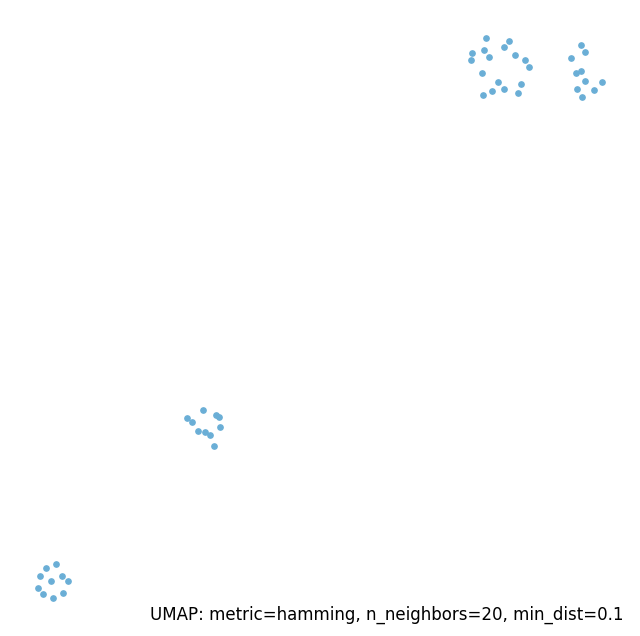

In [14]:
# Embed with umap
umap_model = umap.UMAP(n_neighbors=20, n_components=2, random_state=42, metric='hamming')
umap_emb_data = umap_model.fit_transform(encoded_features)

uplot.points(umap_model)
# 4 groups of data points

/usr/local/lib/python3.10/dist-packages/datashader/transfer_functions/__init__.py:332: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

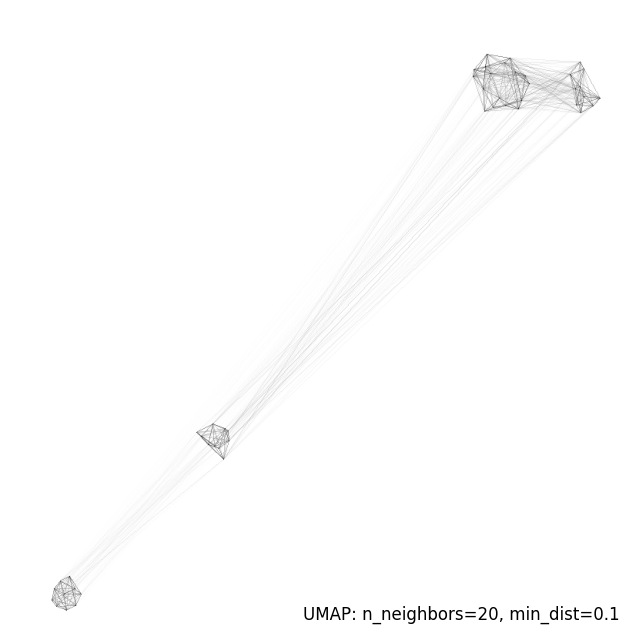

In [15]:
umap.plot.connectivity(umap_model, show_points=True)

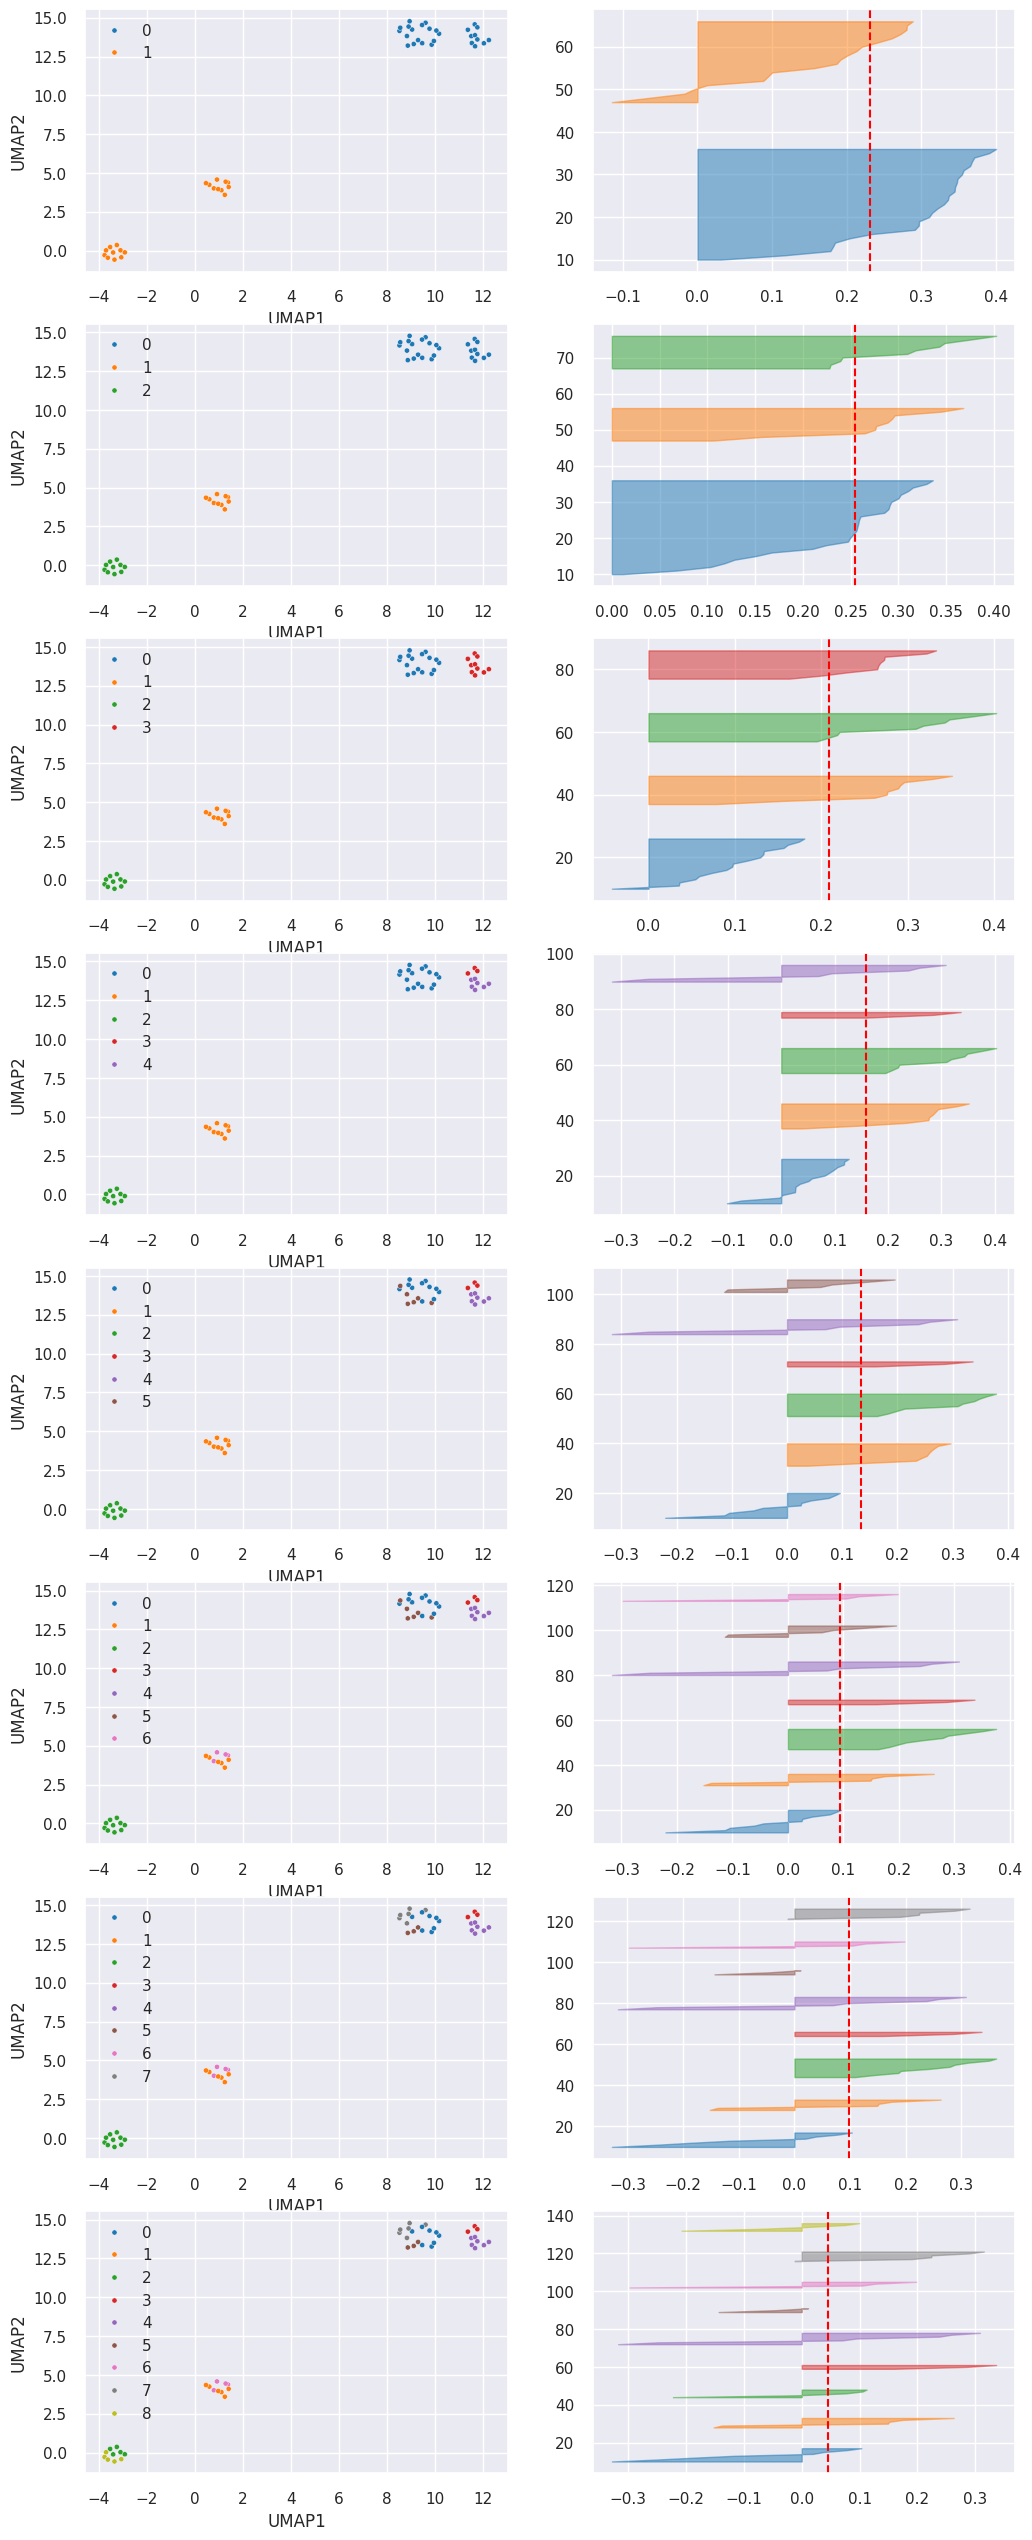

In [16]:
# Perform clustering for multiple k
candidate_k = [2, 3, 4, 5, 6, 7, 8, 9]
tab10 = list(matplotlib.colormaps['tab10'].colors)

cost_list = [] # inertia
silouethe_score_list = []

fig, axs = plt.subplots(
    len(candidate_k), 2,
    figsize=(12, 32)
)

cluster_label_dict = {}
for i, num_clust in enumerate(candidate_k):
    # Perform clustering for current number of clusters
    kmode = KModes(n_clusters=num_clust)
    kmode.fit_predict(encoded_features)

    sns.scatterplot(
        x=umap_emb_data[:,0],
        y=umap_emb_data[:,1],
        hue=kmode.labels_,
        ax=axs[i, 0],
        s=14, palette='tab10'
    )

    axs[i,0].set_xlabel('UMAP1')
    axs[i,0].set_ylabel('UMAP2')

    visualizer = SilhouetteVisualizer(
        kmode,
        is_fitted=True,
        colors=tab10,
        ax=axs[i, 1],
        metric='hamming'
    )
    visualizer = visualizer.fit(encoded_features)

    silouethe_score_list.append(visualizer.silhouette_score_)
    cost_list.append(kmode.cost_)

Text(0.5, 0, 'Number of clusters')

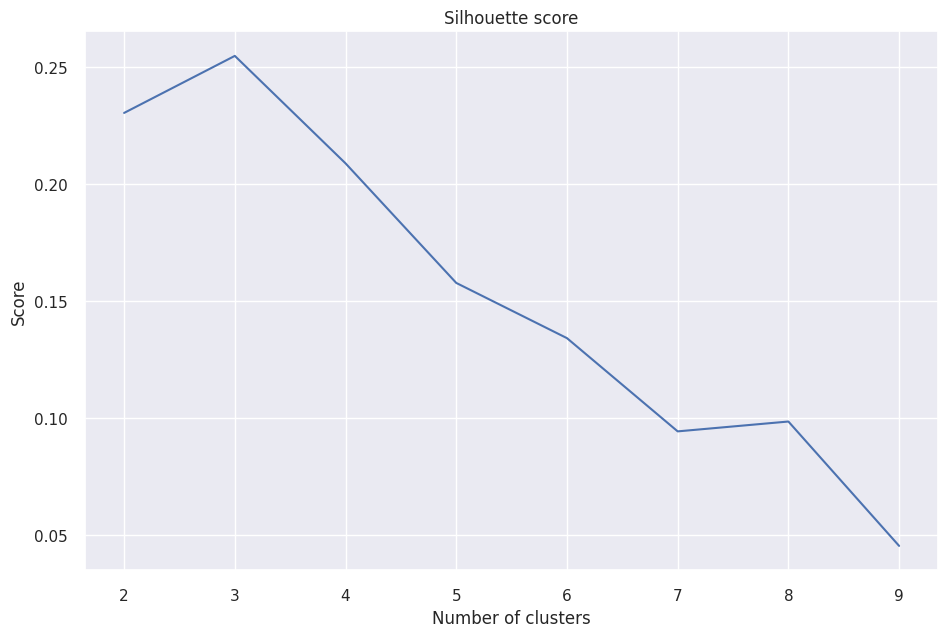

In [17]:
sns.lineplot(x=candidate_k, y=silouethe_score_list)
plt.title('Silhouette score')
plt.ylabel('Score')
plt.xlabel('Number of clusters')

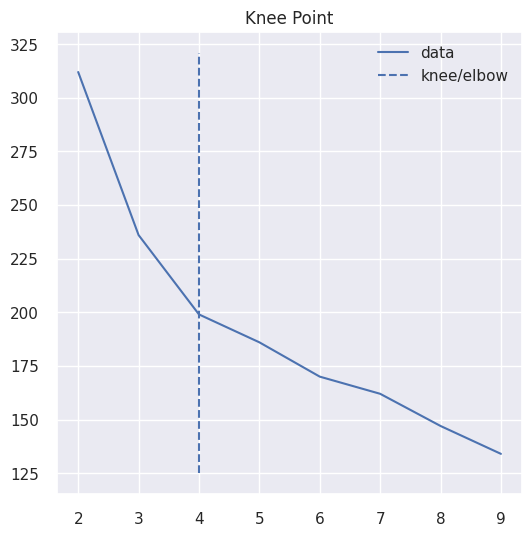

In [18]:
kneedle = KneeLocator(
    candidate_k,
    cost_list,
    S=2,
    curve="convex",
    direction="decreasing"
)
kneedle.plot_knee()

In [19]:
# Perform clustering for 4 clusters
kmode = KModes(n_clusters=4)
cluster_labels = kmode.fit_predict(encoded_features)

adjusted_rand_score(label, cluster_labels)

1.0

### Explore clusters by using stacked bar charts

In [21]:
# you can use these categorical features in order to characterize your clusters

# Add cluster column to stacked bar chart
soy_df['cluster'] = [str(clust) for clust in kmode.labels_]

In [24]:
soy_df.groupby('cluster'), soy_df.groupby('cluster')['date']

(<pandas.core.groupby.generic.DataFrameGroupBy object at 0x7c22fbd6b880>,
 <pandas.core.groupby.generic.SeriesGroupBy object at 0x7c22fbd69c60>)

In [25]:
soy_df.groupby('cluster')['date'].value_counts(normalize=True)

cluster  date     
0         april       0.294118
         may          0.294118
         june         0.235294
         july         0.176471
1        july         0.300000
         october      0.300000
         august       0.200000
         september    0.200000
2        october      0.300000
         september    0.300000
         august       0.200000
         july         0.200000
3         april       0.500000
         june         0.300000
         august       0.100000
         july         0.100000
Name: proportion, dtype: float64

In [26]:
proportions = soy_df.groupby(
    'cluster'
)['date'].value_counts(
    normalize=True
).unstack() # unstack(): to get rid of double indexes which will be created by this group by
proportions
# we want to translate this into a bar chart which is stacked meaning that
# it will have fractions with size corresponding to these frequencies

date,april,august,july,june,may,october,september
cluster,,,,,,,
0,0.294118,NaN,0.176471,0.235294,0.294118,NaN,NaN
1,NaN,0.2,0.300000,NaN,NaN,0.3,0.2
2,NaN,0.2,0.200000,NaN,NaN,0.3,0.3
3,0.500000,0.1,0.100000,0.300000,NaN,NaN,NaN


Feature - date: 
 Represents the specific time of soybean sample collection, crucial for understanding seasonal impacts on plant health.


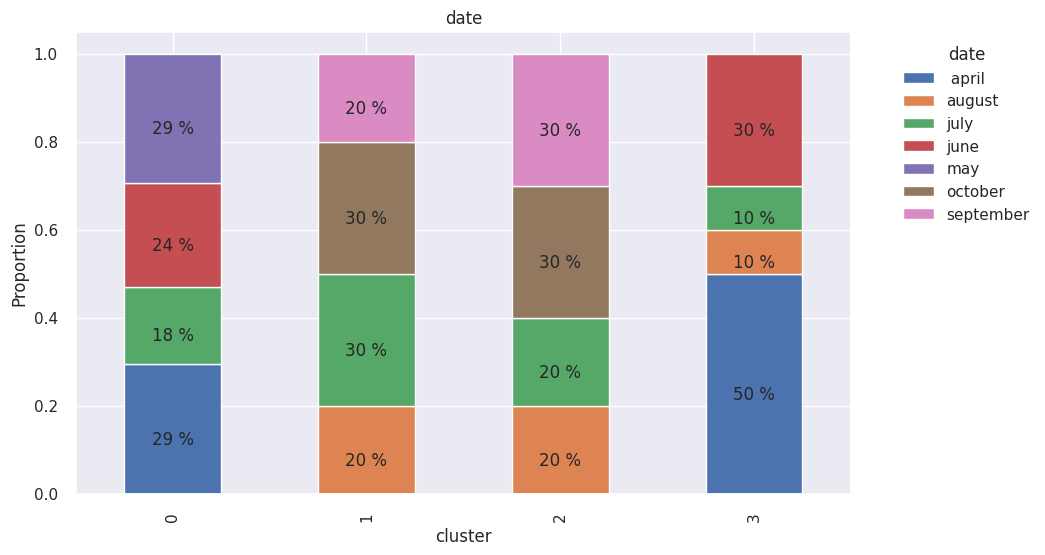

Feature - plant-stand: 
 Qualitatively assesses the uniformity and health of the plant population, informing about possible early-stage diseases or growth issues.


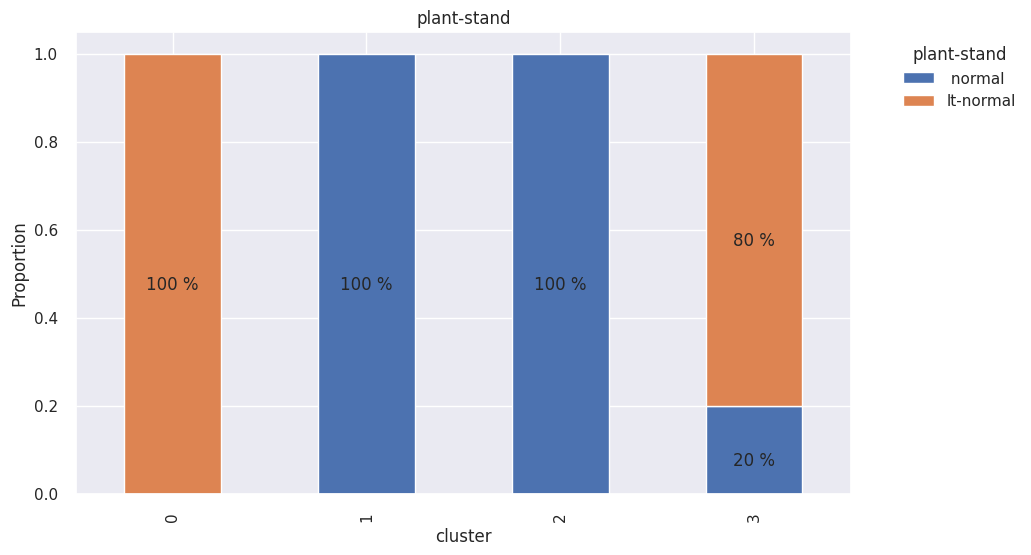

Feature - precip: 
 Captures the water level conditions around the sampling time, providing insights into potential water-related stress factors.


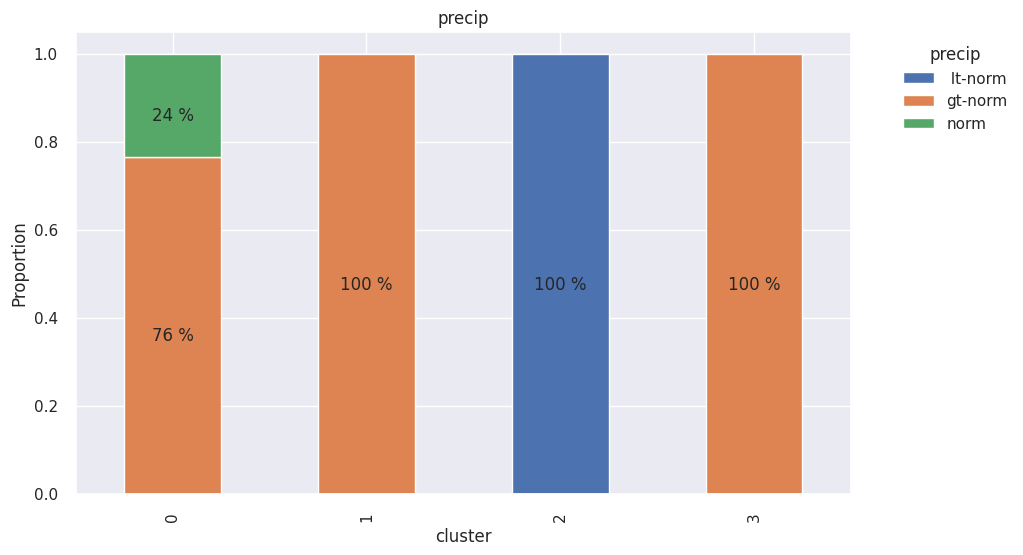

Feature - temp: 
 Reflects the average climatic temperature at the time of observation, crucial for assessing environmental stress conditions.


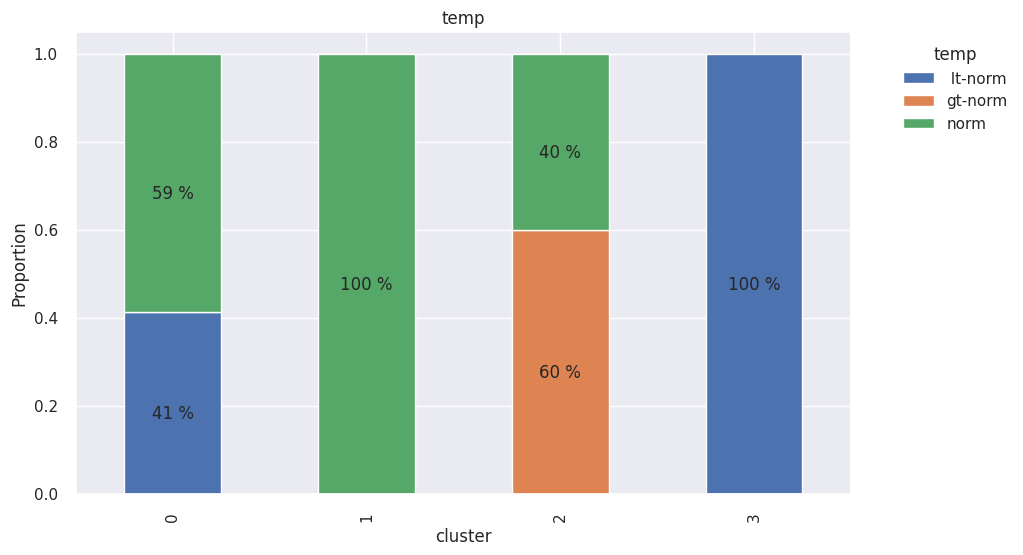

Feature - hail: 
 A binary indicator that identifies whether the plant has undergone hail damage, which could affect overall plant health.


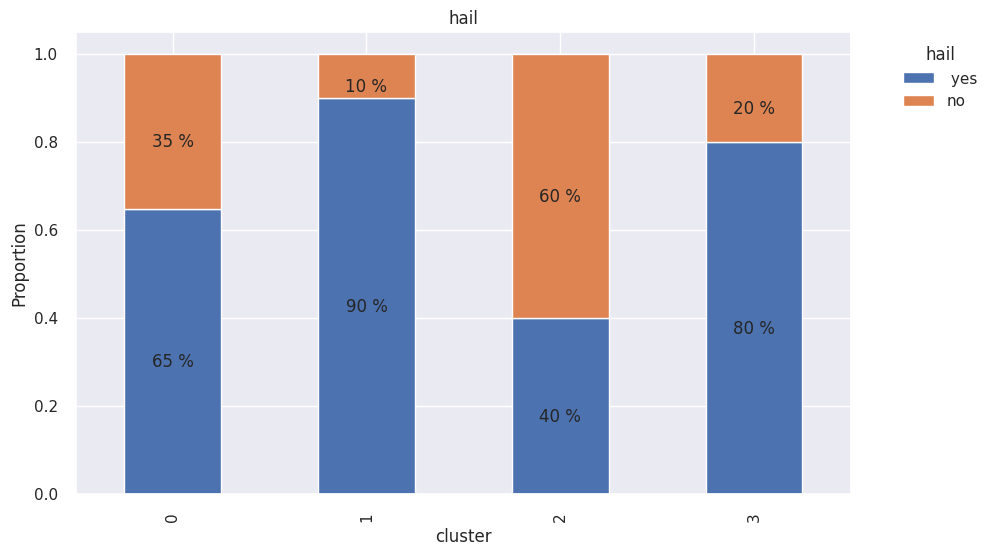

Feature - crop-hist: 
 Denotes the type of crop previously grown in the same field, essential for understanding soil quality and disease carryover risks.


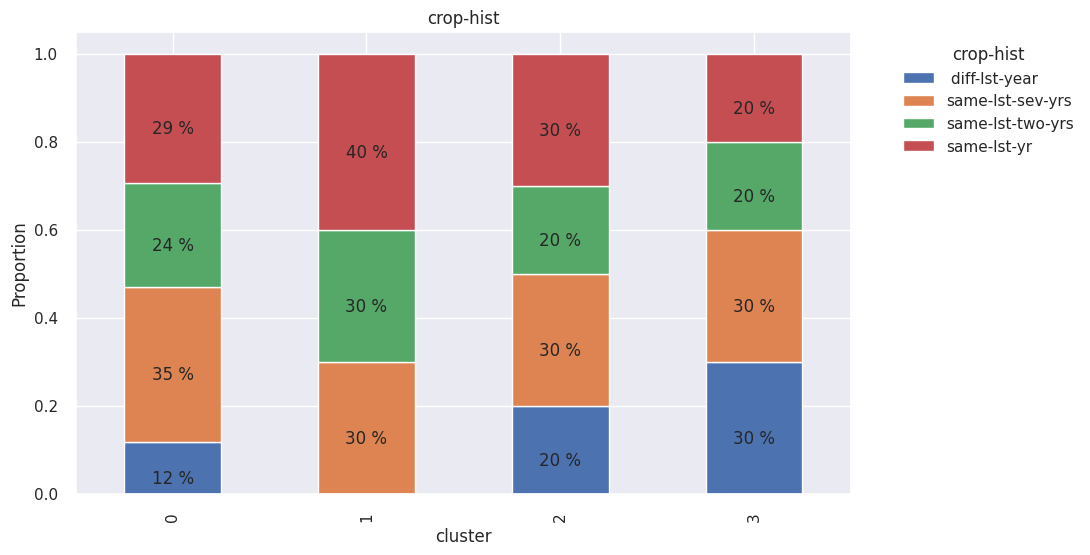

Feature - area-damaged: 
 Quantifies the spatial extent of observable damage, useful for gauging the disease's progression.


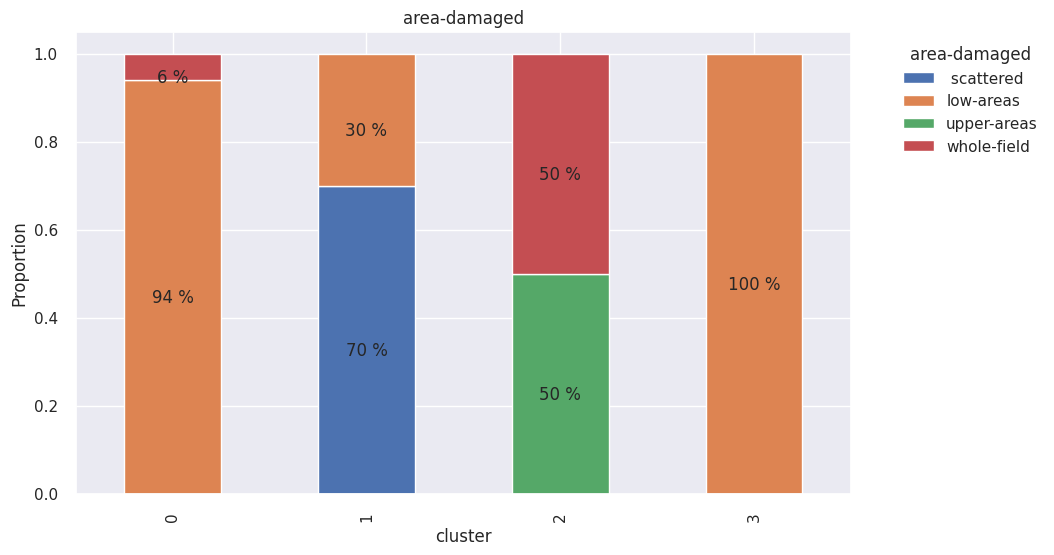

Feature - severity: 
 Categorizes the observable symptoms into different severity levels, aiding in diagnostic precision.


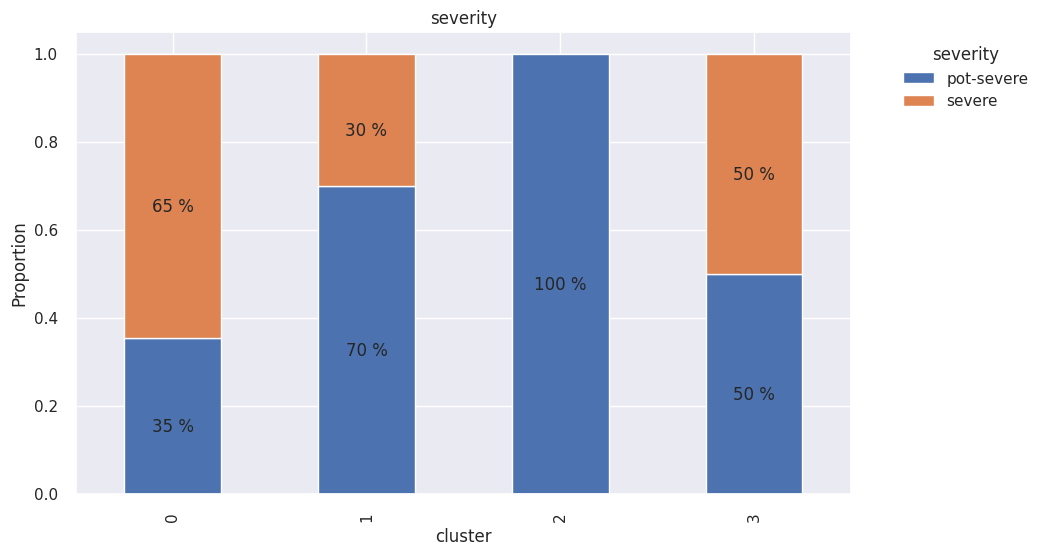

Feature - seed-tmt: 
 Indicates whether the seeds underwent any treatment before planting, offering clues to possible resistance against diseases.


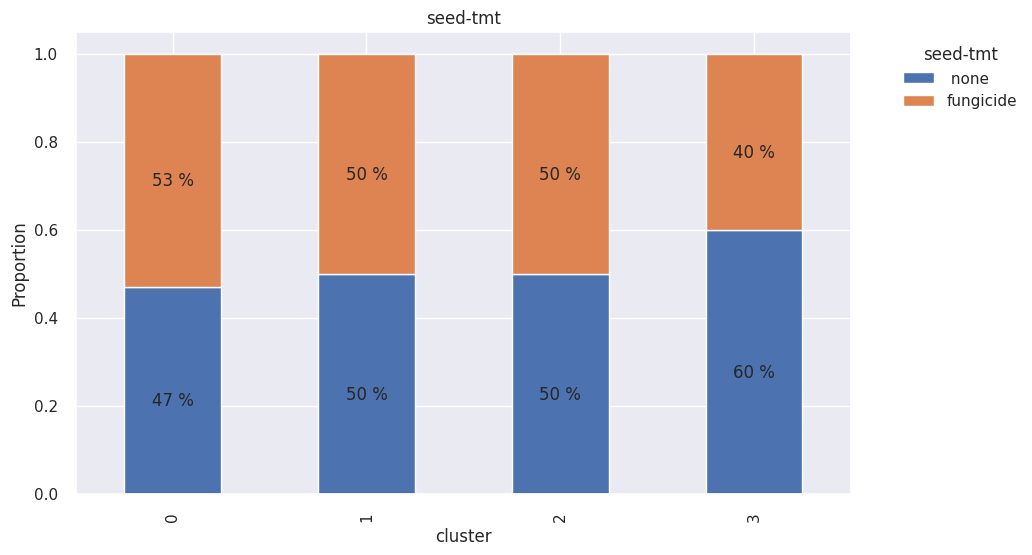

Feature - germination: 
 Measures the proportion of seeds that successfully sprouted, a potential early indicator of crop health.


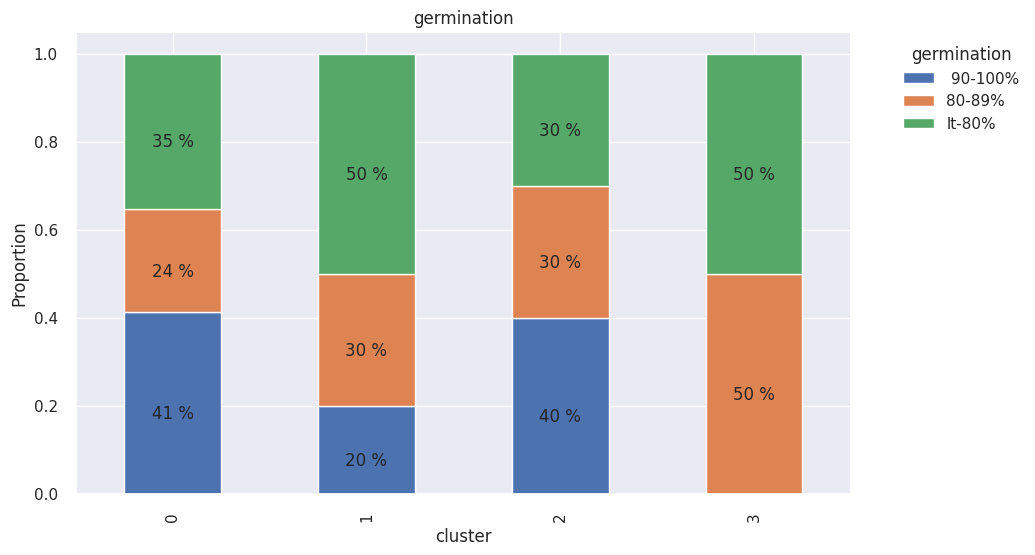

Feature - leaves: 
 Evaluates leaf condition, which is often the first site of symptom expression in many plant diseases.


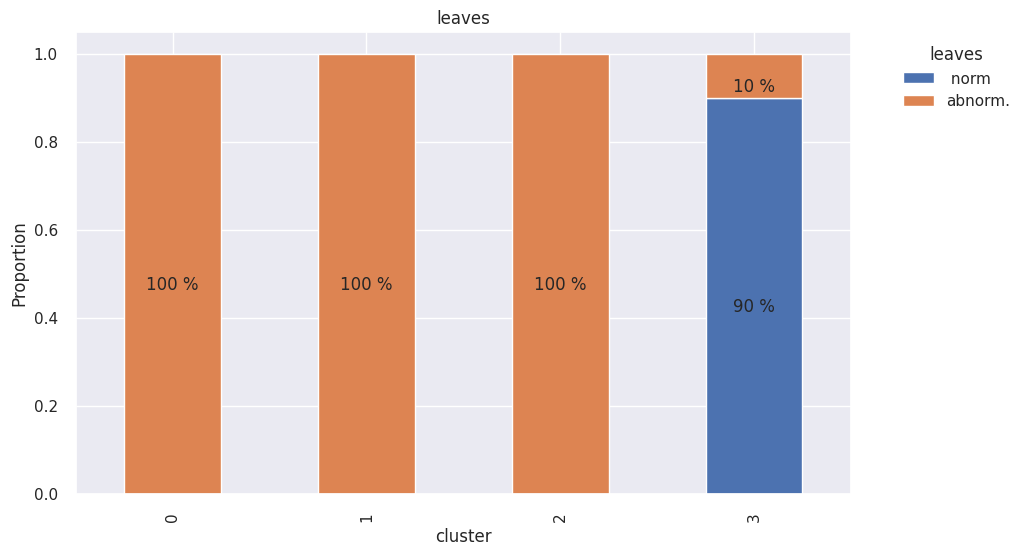

Feature - lodging: 
 A binary flag that notes whether the plant is upright or has fallen, often indicative of structural weakness or disease.


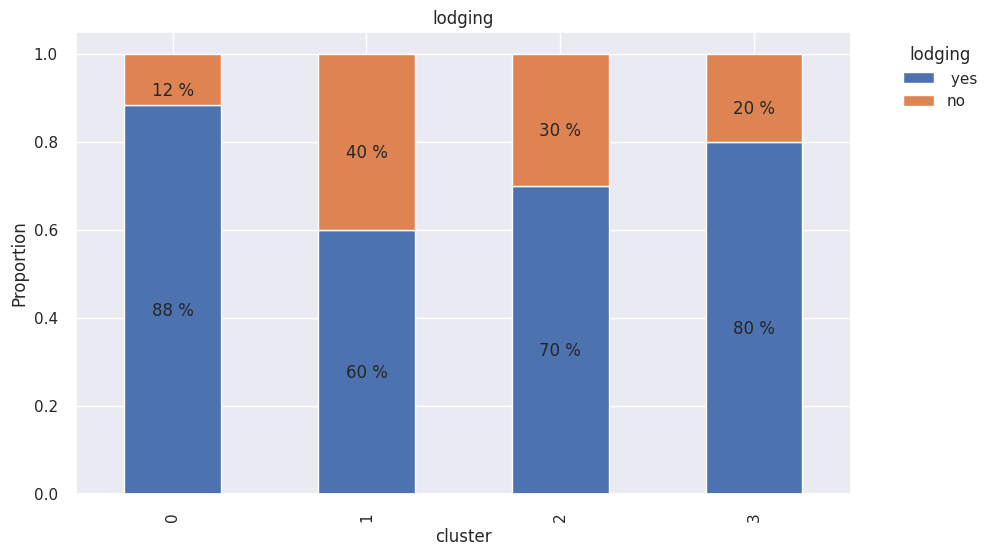

Feature - stem-cankers: 
 Details the characteristics of stem cankers if present, essential for identifying specific stem diseases.


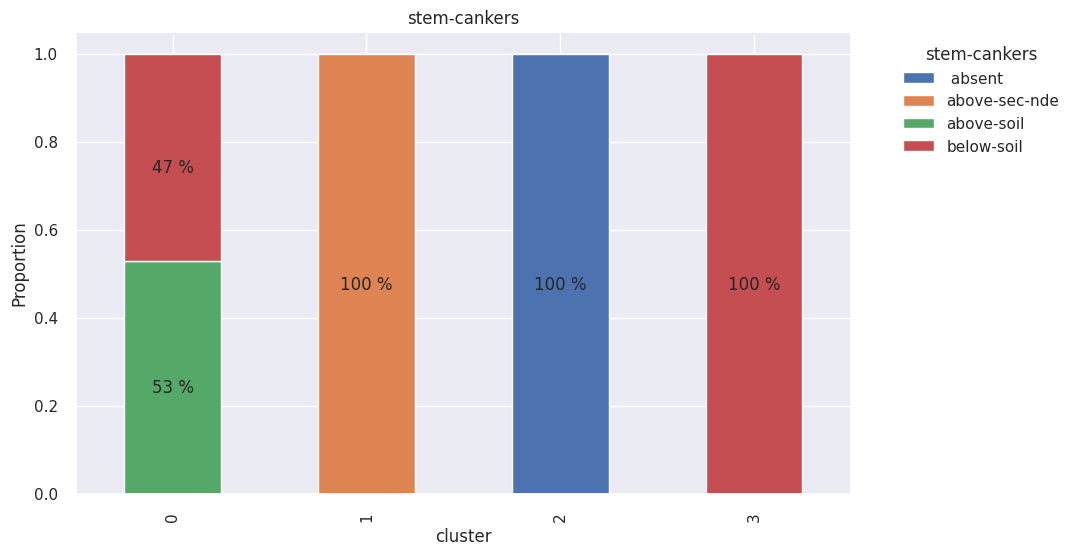

Feature - canker-lesion: 
 Documents the type and appearance of canker lesions on the stem, crucial for diagnostic accuracy.


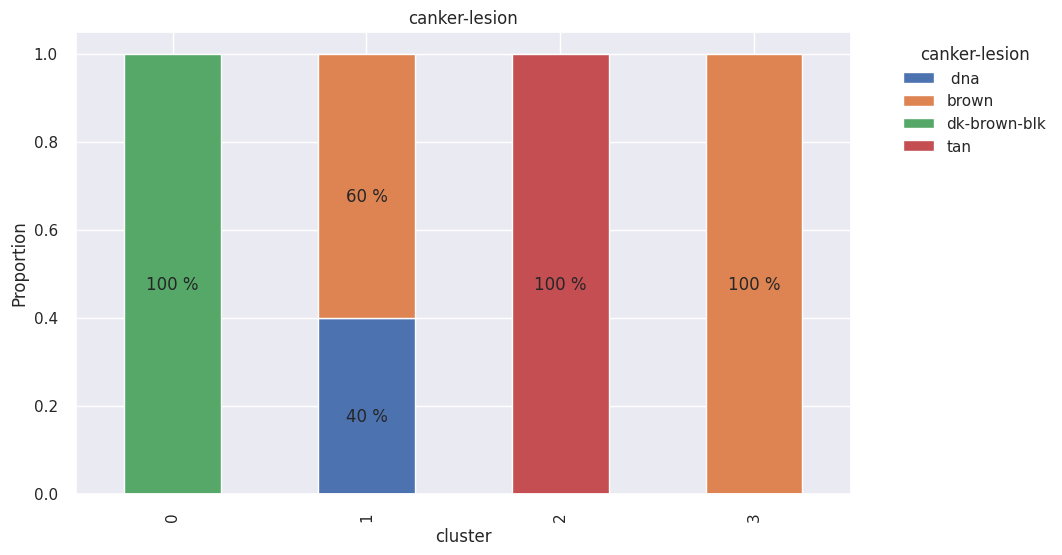

Feature - fruiting-bodies: 
 A binary indicator of the presence of fruiting bodies, suggesting advanced stages of certain fungal diseases.


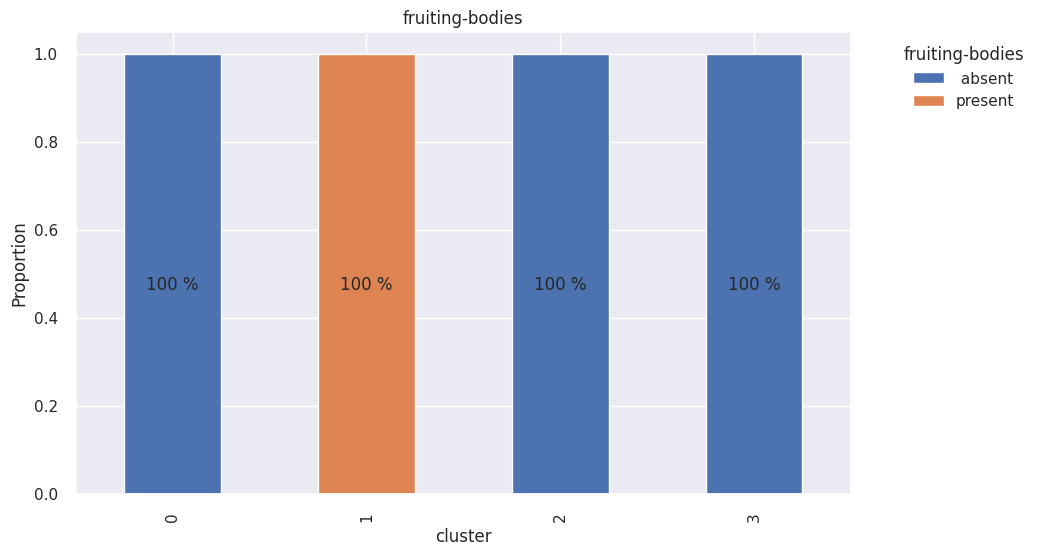

Feature - external decay: 
 Flags the presence of decay on the plant's exterior, indicative of severe fungal or bacterial infection.


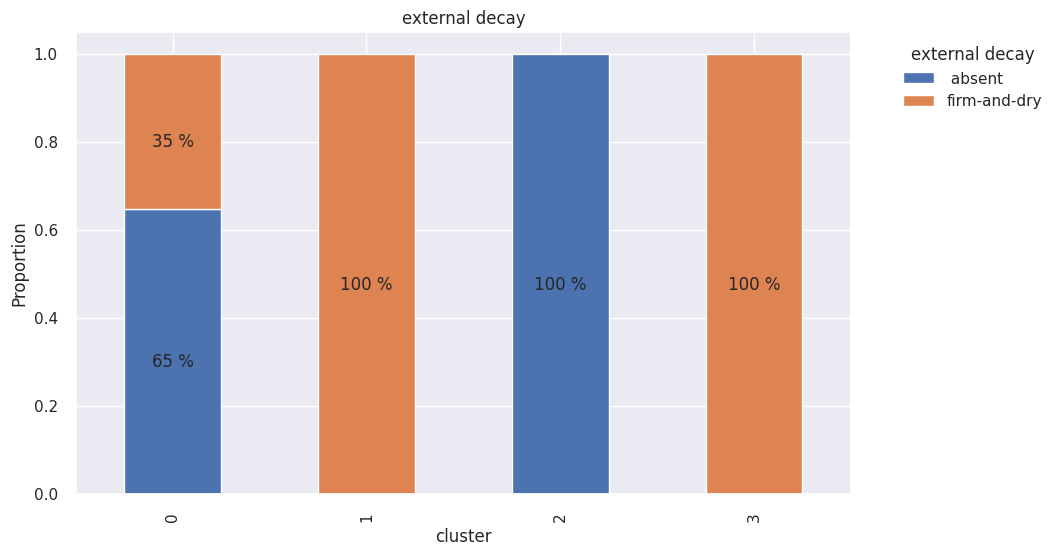

Feature - mycelium: 
 A binary indicator for the presence of fungal mycelium, a sign of fungal diseases.


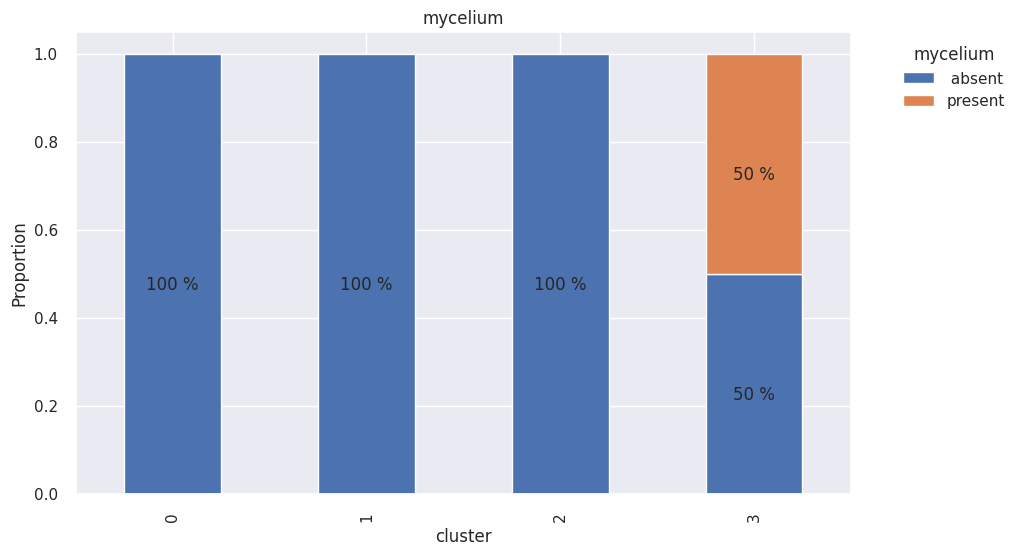

Feature - int-discolor: 
 Flags internal discoloration, often indicative of systemic infections.


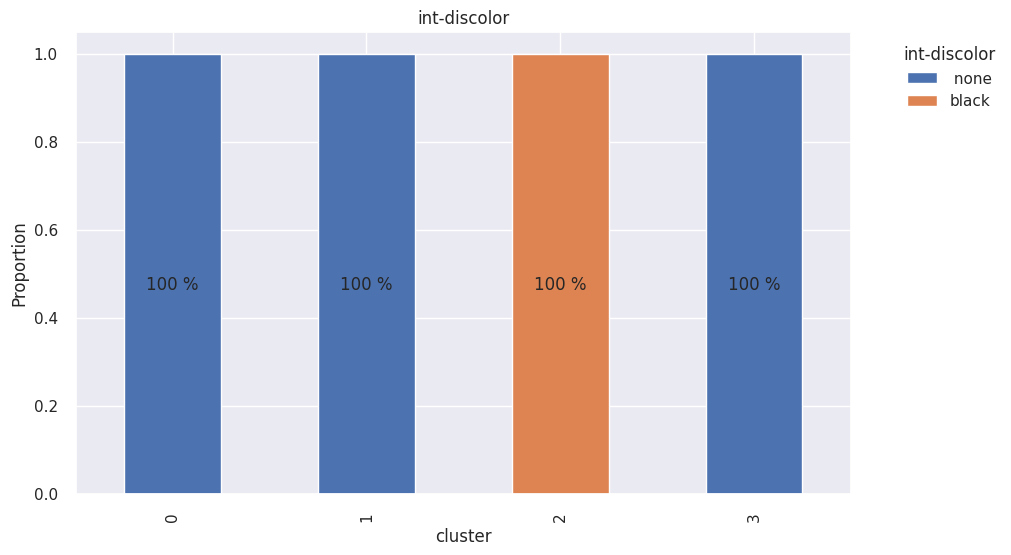

Feature - sclerotia: 
 Indicates the presence of sclerotial bodies, commonly associated with advanced fungal diseases.


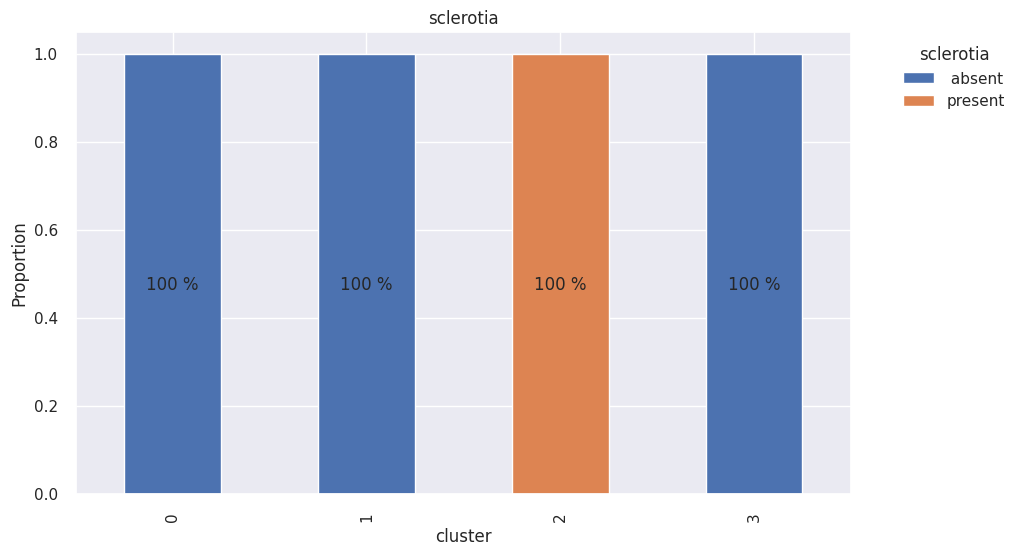

Feature - fruit-pods: 
 Evaluates the overall health of the fruit pods, crucial for assessing the final yield quality.


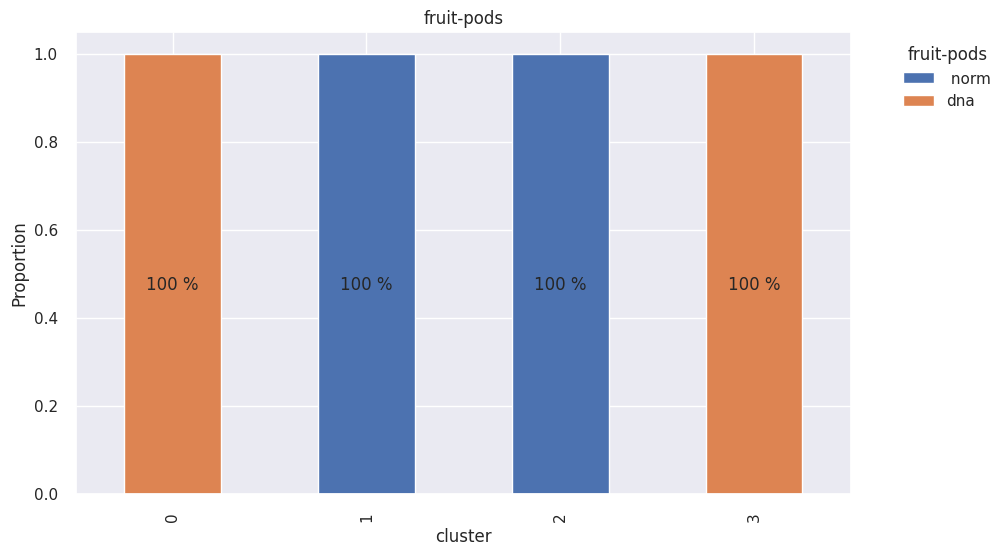

Feature - roots: 
 Assesses root health, providing insights into soil-borne diseases and nutritional deficiencies.


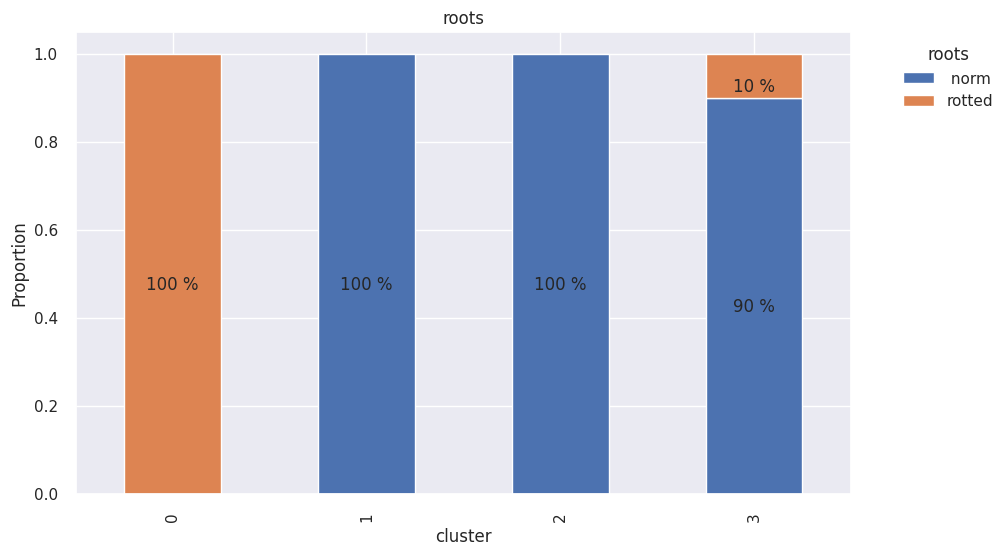

In [27]:
for col in soy_df.columns:
    if col != 'cluster':
        # Calculate proportions
        proportions = soy_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()

        print('Feature - {}: \n {}'.format(col, SOY_FEATURE_DESCRIPTION[col]))

        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

        plt.title(col)
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels to the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy() # starting point of each section

                ax.text(x+width/2,
                        y+height/2,
                        '\n{:.0f} %'.format(height*100),
                        horizontalalignment='center',
                        verticalalignment='center')

        plt.show()